In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn import preprocessing
import sklearn.feature_selection as fs
import pickle
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sys import stdout
import math
import plotly.express as px
import matplotlib as mpl
import matplotlib.patches as mpatches

In [32]:
!git clone https://github.com/Honf103/Dataegg_conference.git

fatal: destination path 'Dataegg_conference' already exists and is not an empty directory.


In [33]:
df_mid = pd.read_csv ('/content/Dataegg_conference/Raw_data_mid.csv')
df_bot = pd.read_csv ('/content/Dataegg_conference/Raw_data_bot.csv')
df_top = pd.read_csv ('/content/Dataegg_conference/Raw_data_top.csv')

In [34]:
df_mid = df_mid[['R_610nm','S_680nm','T_730nm', 'U_760nm', 'V_810nm', 'W_860nm', 'HU']]
df_bot = df_bot[['R_610nm','S_680nm','T_730nm', 'U_760nm', 'V_810nm', 'W_860nm', 'HU']]
df_top = df_top[['R_610nm','S_680nm','T_730nm', 'U_760nm', 'V_810nm', 'W_860nm', 'HU']]

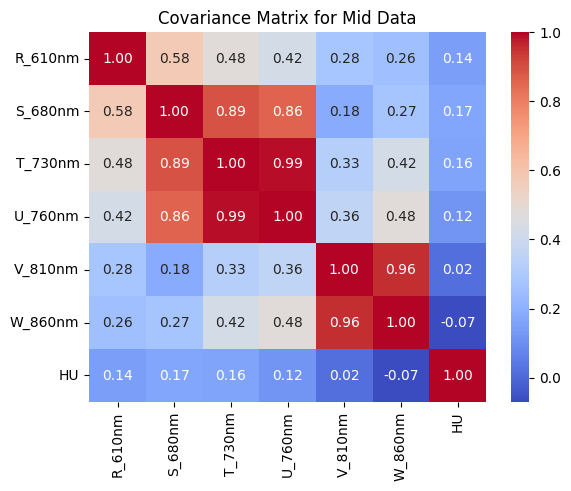

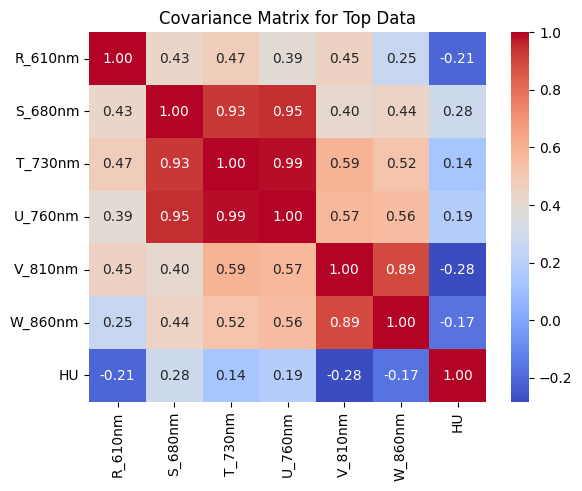

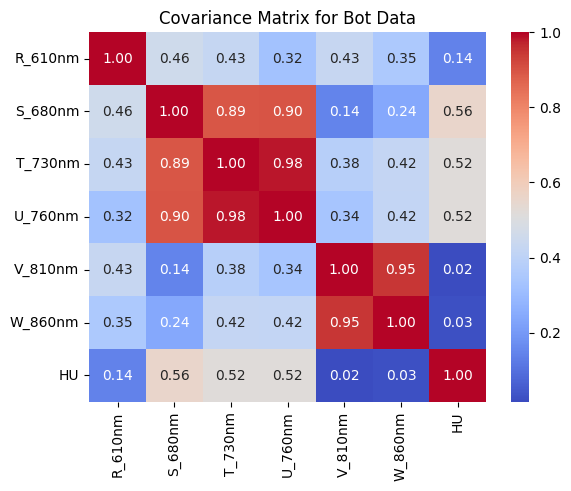

In [47]:

import seaborn as sns

df_mid = df_mid.round(2)
df_top = df_top.round(2)
df_bot = df_bot.round(2)

def covariance_matrix_plot(df, name):
  corr = df.corr()
  sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
  plt.title(f"Covariance Matrix for {name} Data")
  plt.savefig(f"{name}_covariance_matrix.png")
  plt.show()

covariance_matrix_plot(df_mid, "Mid")
covariance_matrix_plot(df_top, "Top")
covariance_matrix_plot(df_bot, "Bot")


In [35]:

from sklearn.model_selection import train_test_split

X_train_mid, X_test_mid, y_train_mid, y_test_mid = train_test_split(df_mid, df_mid['HU'], test_size=0.1, random_state=42)
X_train_bot, X_test_bot, y_train_bot, y_test_bot = train_test_split(df_bot, df_bot['HU'], test_size=0.1, random_state=42)
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(df_top, df_top['HU'], test_size=0.1, random_state=42)


In [36]:

scaler = StandardScaler()
X_train_mid = scaler.fit_transform(X_train_mid)
X_test_mid = scaler.fit_transform(X_test_mid)

X_train_bot = scaler.fit_transform(X_train_bot)
X_test_bot = scaler.fit_transform(X_test_bot)

X_train_top = scaler.fit_transform(X_train_top)
X_test_top = scaler.fit_transform(X_test_top)

In [37]:
def snv(X):
    corrected_spectra = np.zeros_like(X)

    for i in range(X.shape[0]):
        mean = np.mean(X[i, :])
        std_dev = np.std(X[i, :])
        corrected_spectra[i, :] = (X[i, :] - mean) / std_dev

    return corrected_spectra


In [38]:
def msc(X):
    mean_spectrum = np.mean(X, axis=0)
    corrected_spectra = np.zeros_like(X)

    for i in range(X.shape[0]):
        fit = np.polyfit(mean_spectrum, X[i, :], 1, full=True)
        slope = fit[0][0]
        intercept = fit[0][1]
        corrected_spectra[i, :] = (X[i, :] - intercept) / slope

    return corrected_spectra

Use StandardScaler to preprocessing data

In [39]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 8, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_mid = GridSearchCV(model, param_grid, cv=5)
grid_search_top = GridSearchCV(model, param_grid, cv=5)
grid_search_bot = GridSearchCV(model, param_grid, cv=5)

grid_search_mid.fit(X_train_mid, y_train_mid)
grid_search_top.fit(X_train_top, y_train_top)
grid_search_bot.fit(X_train_bot, y_train_bot)


y_pred_mid = grid_search_mid.predict(X_test_mid)
y_pred_top = grid_search_top.predict(X_test_top)
y_pred_bot = grid_search_bot.predict(X_test_bot)

r2_score_mid = r2_score(y_test_mid, y_pred_mid)
r2_score_top = r2_score(y_test_top, y_pred_top)
r2_score_bot = r2_score(y_test_bot, y_pred_bot)

print("R2 mid score:", r2_score_mid)
print("R2 top score:", r2_score_top)
print("R2 bot score:", r2_score_bot)


R2 mid score: 0.9658050621273345
R2 top score: 0.9662091380096786
R2 bot score: 0.9658829878977443


Using SNV to preprocessing data

In [40]:
X_train_mid = snv(X_train_mid)
X_test_mid = snv(X_test_mid)

X_train_bot = snv(X_train_bot)
X_test_bot = snv(X_test_bot)

X_train_top = snv(X_train_top)
X_test_top = snv(X_test_top)

In [41]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the RandomForestRegressor model
model = RandomForestRegressor()

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 8, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search_mid = GridSearchCV(model, param_grid, cv=5)
grid_search_top = GridSearchCV(model, param_grid, cv=5)
grid_search_bot = GridSearchCV(model, param_grid, cv=5)

grid_search_mid.fit(X_train_mid, y_train_mid)
grid_search_top.fit(X_train_top, y_train_top)
grid_search_bot.fit(X_train_bot, y_train_bot)


# Predict on test set
y_pred_mid = grid_search_mid.predict(X_test_mid)
y_pred_top = grid_search_top.predict(X_test_top)
y_pred_bot = grid_search_bot.predict(X_test_bot)

# Calculate and print R2 score
r2_score_mid = r2_score(y_test_mid, y_pred_mid)
r2_score_top = r2_score(y_test_top, y_pred_top)
r2_score_bot = r2_score(y_test_bot, y_pred_bot)

print("R2 mid score:", r2_score_mid)
print("R2 top score:", r2_score_top)
print("R2 bot score:", r2_score_bot)


R2 mid score: 0.5384511785426678
R2 top score: 0.6404434501393006
R2 bot score: 0.40401234001876096


Using MSC to preprocessing data

In [42]:
X_train_mid = msc(X_train_mid)
X_test_mid = msc(X_test_mid)

X_train_bot = msc(X_train_bot)
X_test_bot = msc(X_test_bot)

X_train_top = msc(X_train_top)
X_test_top = msc(X_test_top)

In [43]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the RandomForestRegressor model
model = RandomForestRegressor()

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 8, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search_mid = GridSearchCV(model, param_grid, cv=5)
grid_search_top = GridSearchCV(model, param_grid, cv=5)
grid_search_bot = GridSearchCV(model, param_grid, cv=5)

grid_search_mid.fit(X_train_mid, y_train_mid)
grid_search_top.fit(X_train_top, y_train_top)
grid_search_bot.fit(X_train_bot, y_train_bot)


# Predict on test set
y_pred_mid = grid_search_mid.predict(X_test_mid)
y_pred_top = grid_search_top.predict(X_test_top)
y_pred_bot = grid_search_bot.predict(X_test_bot)

# Calculate and print R2 score
r2_score_mid = r2_score(y_test_mid, y_pred_mid)
r2_score_top = r2_score(y_test_top, y_pred_top)
r2_score_bot = r2_score(y_test_bot, y_pred_bot)

print("R2 mid score:", r2_score_mid)
print("R2 top score:", r2_score_top)
print("R2 bot score:", r2_score_bot)


R2 mid score: -0.08320933046999723
R2 top score: 0.0007763369505250362
R2 bot score: 0.11212355659383433
